In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

from sepia.SepiaData import SepiaData
from sepia.SepiaModelSetup import setup_model

In [2]:
# Load raw data
sim_s104 = np.genfromtxt('data/features_cdf104S.csv', delimiter=',', skip_header=1)
sim_s105 = np.genfromtxt('data/features_cdf105S.csv', delimiter=',', skip_header=1)
sim_s106 = np.genfromtxt('data/features_cdf106S.csv', delimiter=',', skip_header=1)

obs_s104 = np.genfromtxt('data/features_cdf_obs104S.csv', delimiter=',', skip_header=1)
obs_s105 = np.genfromtxt('data/features_cdf_obs105S.csv', delimiter=',', skip_header=1)
obs_s106 = np.genfromtxt('data/features_cdf_obs106S.csv', delimiter=',', skip_header=1)

design = np.loadtxt('data/Al.trial5.design.txt', skiprows=1)
with open('data/Al.trial5.design.txt', 'r') as f:
    design_names = str.split(f.readline())

# Preprocess data
sel_features = [3, 5, 7, 9]
y_sim = 10000 * np.concatenate([sim_s104[:, sel_features], sim_s105[:, sel_features], sim_s106[:, sel_features]], axis=1)
y_obs = np.concatenate([obs_s104[sel_features], obs_s105[sel_features], obs_s106[sel_features]])[None, :]
n_features = y_obs.shape[1]
y_ind = np.arange(1, n_features+1)

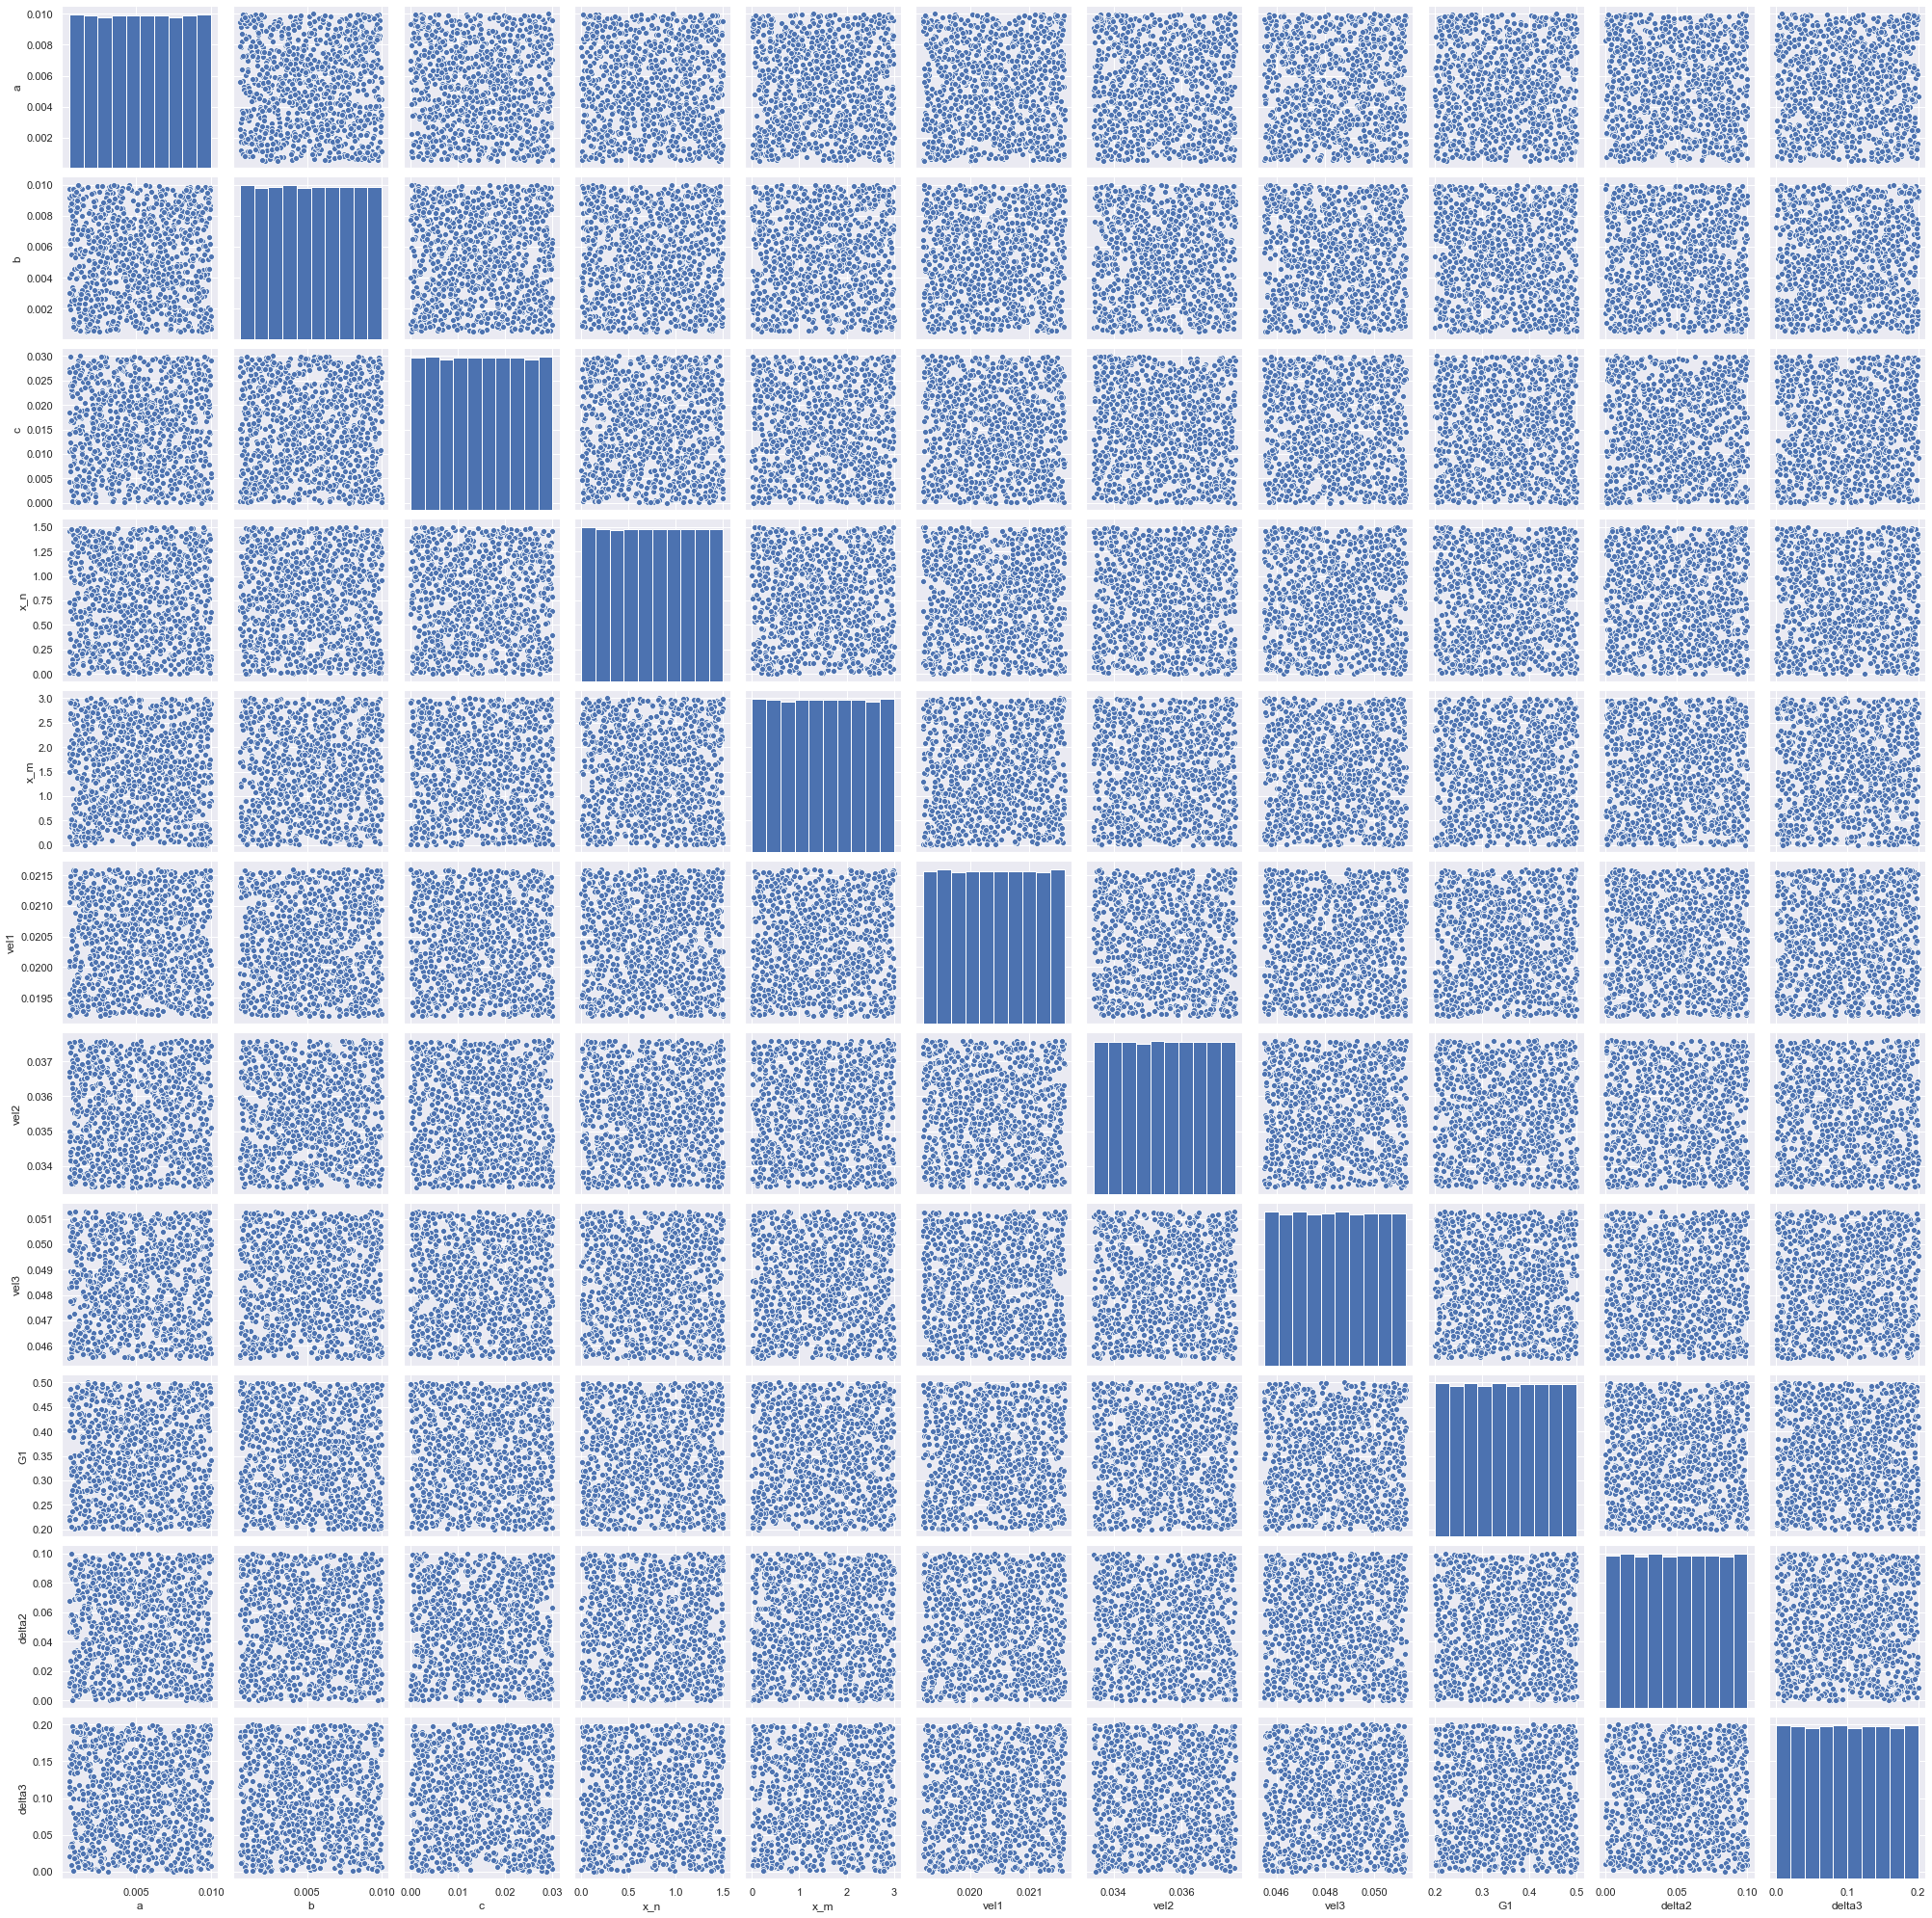

In [3]:
# Plot design
design_df = pd.DataFrame(data=design, columns=design_names)

with sns.plotting_context("notebook", font_scale=5.5):
    sns.pairplot(design_df)
plt.show()

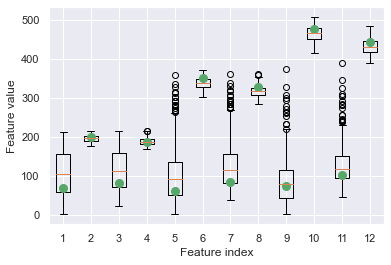

In [4]:
# Plot data
plt.boxplot(y_sim)
plt.plot(y_ind, y_obs.T, 'go', markersize=8)
plt.ylabel('Feature value')
plt.xlabel('Feature index')
plt.show()

In [5]:
# Set up sepia model
data = SepiaData(t_sim=design, y_sim=y_sim, y_ind_sim=y_ind, y_obs=y_obs, y_ind_obs=y_ind)
data.standardize_y()
data.transform_xt()
data.create_K_basis(n_features)
print(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 12, obs y dimension 12
n  =     1 (number of observed data)
m  =  1000 (number of simulated data)
p  =     1 (number of inputs)
q  =    11 (number of additional simulation inputs to calibrate)
pu =    12 (transformed response dimension)
pv NOT SET (transformed discrepancy dimension); call method create_D_basis



In [6]:
# Setup model
# We have a known observation error
Sigy = np.diag(np.squeeze((0.01 * np.ones(n_features) * y_obs)/data.sim_data.y_sd**2))
model = setup_model(data, Sigy)

To use one, call data.create_D_basis on your SepiaData object.


In [7]:
# Do mcmc
model.do_mcmc(5000)
samples_dict = {p.name: p.mcmc_to_array(trim=500) for p in model.params.mcmcList}

MCMC sampling: 100%|██████████| 5000/5000 [15:47:38<00:00, 11.37s/it]  


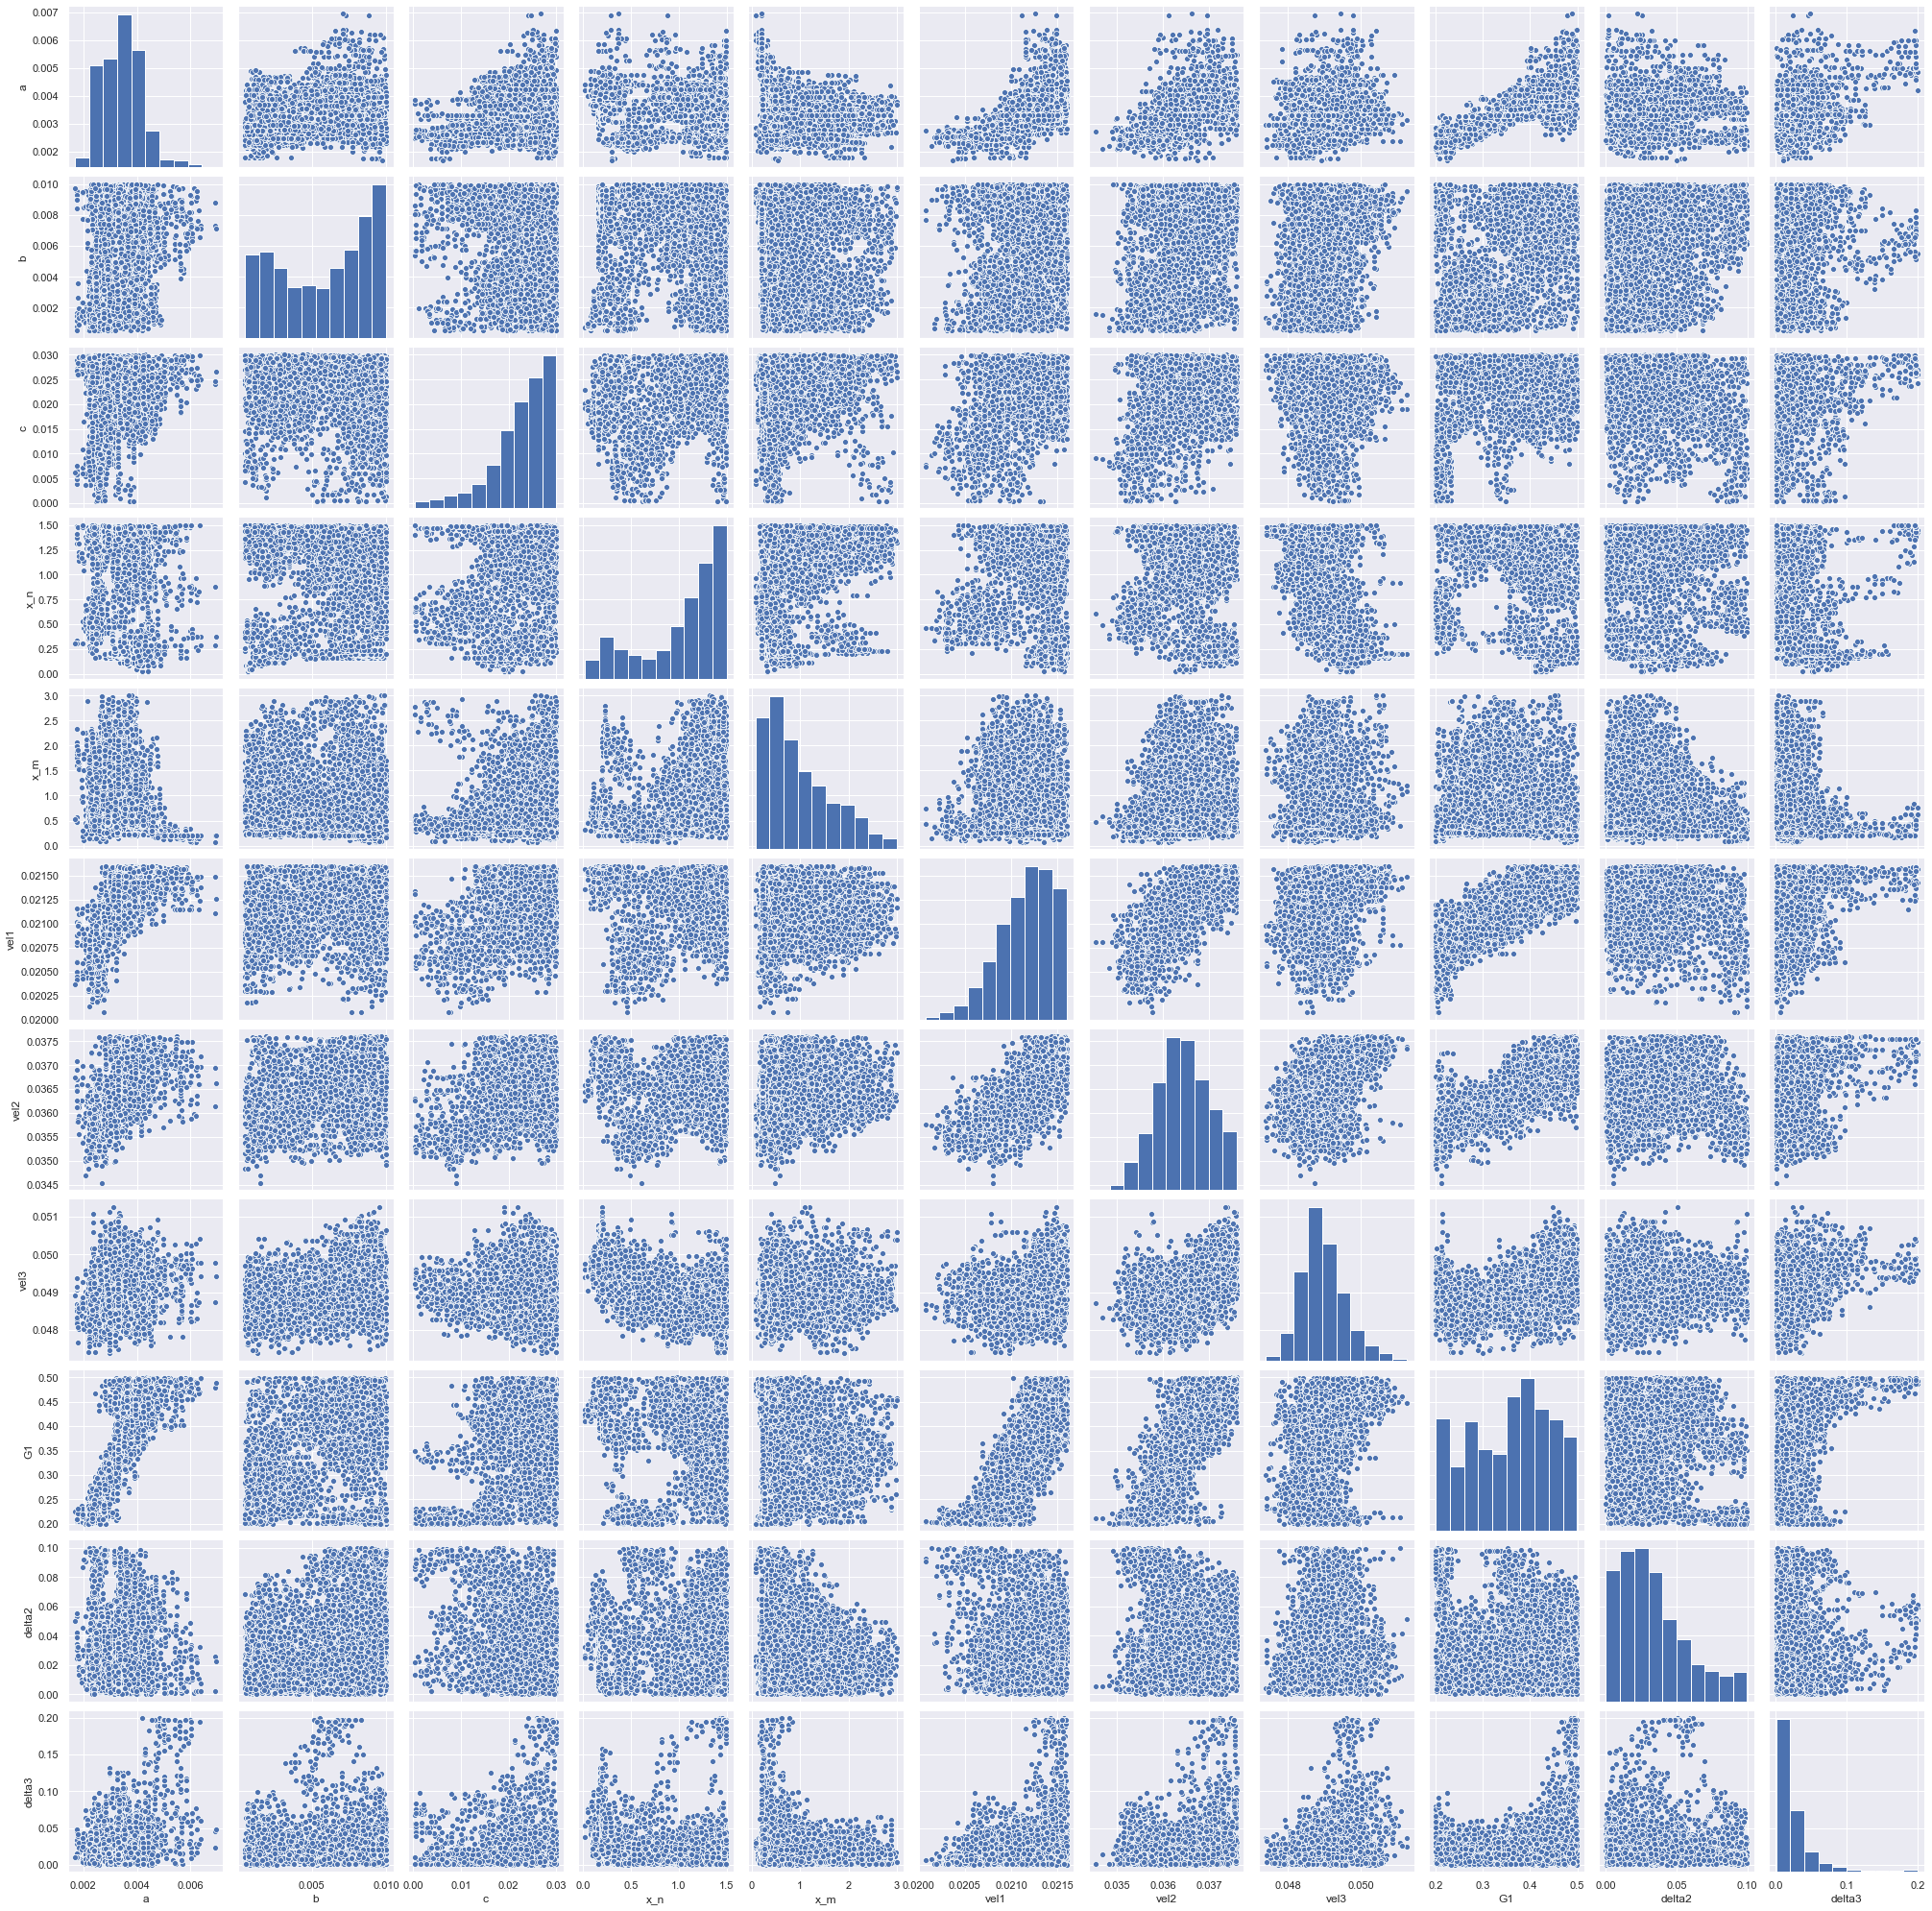

In [8]:
# Pair plot of thetas
t_min = np.min(design, 0)
t_max = np.max(design, 0)
theta = samples_dict['theta'] * (t_max - t_min) + t_min
theta_df = pd.DataFrame(data=theta, columns=design_names)

with sns.plotting_context("notebook", font_scale=5.5):
    sns.pairplot(theta_df)
plt.show()